In [ ]:
# Settings and packages

from __future__ import division
import sys
import math
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rc
import numpy as np
from keras.layers import Dense, Input, Activation, Layer, Flatten, Reshape
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
from keras.constraints import Constraint
from keras import backend as K
from tqdm import tqdm


font = {'family' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)

# Some global constants


n_TA_train = 6
TA_train = [0,6,12,18,24,30]
TA_test = [0,3,6,9,12,15,18,21,24,27,30]
n_TA_test = 11

Nparticles = 312
Ndistances = 25
rho = 1

ngaussians = 40
std = 0.05
cutoff = 4
gaussianmeans = np.linspace(0, cutoff, ngaussians)
gaussianmeans = tf.convert_to_tensor(value=gaussianmeans, dtype='float32')

kap = 4
amplitude = 50

def fr(r):
    if r < 2.5:
        ekr = np.exp(-1.0*kap*r)
        dudr = - amplitude * (kap*ekr/r + ekr/(r**2))
        dduddr = amplitude * (kap*ekr/(r**2) + 2*ekr/(r**3))        
        return dudr**2 - (dduddr + 1/r*dudr)
    else:
        return 0
    
def map_Y_to_means_numpy(y, means):
    i = 0
    dist = max(np.power((means-np.ones(len(means))*y), 2))
    for j in range(len(means)):
        if (y-means[j])**2 < dist:
            i = j
            dist = (y-means[j])**2
    return means[i]

# Creating test data

means_test = np.zeros(n_TA_test)

n = 1000;

X_test = np.zeros((n*n_TA_test, Nparticles*2, Ndistances))
Y_test = np.zeros(n*n_TA_test)

for i in range(n_TA_test):
    X_local = np.reshape(np.load('X_TA' + str(TA_test[i]) + '.0.npy'), (6000,2*Nparticles,Ndistances))
    Y_local = np.reshape(np.load('Y_TA'  + str(TA_test[i]) + '.0.npy'), 6000)
    
    Y_local = Y_local + 55.48*0.255
    means_test[i] = np.mean(Y_local)
    Y_output = np.ones(len(Y_local))*means_test[i]
    
    X_test[i*n:(i+1)*n, :, :] = X_local[:n,:,:]
    Y_test[i*n:(i+1)*n] = Y_output[:n]

rescale = np.load('Trial_1/rescale.npy')  # rescale should be the same
    
Y_test = Y_test/rescale

means_test = means_test/rescale


In [ ]:
av_dotw = np.zeros(n_TA_test)
store_dotw = np.zeros((n_TA_test,10))
av_dotw_real = np.zeros(n_TA_test)
av_learned_Rr = np.zeros(300)
av_real_Rr = np.zeros(300)
    
for trial in tqdm(range(10)):
    dotw = np.zeros(n_TA_test)
    dotw_real = np.zeros(n_TA_test)

    weights = np.load('Trial_'+str(trial+1)+'/weights_Fr.npy', allow_pickle=True)
    w = np.load('Trial_'+str(trial+1)+'/weights_w.npy', allow_pickle=True)
    Y_pred = np.reshape(np.load('Trial_'+str(trial+1)+'/Y_pred_test.npy', allow_pickle=True), len(Y_test))

    for j in tqdm(range(n_TA_test)):
        index = 0
        for k in range(len(Y_test)):
            if map_Y_to_means_numpy(Y_test[k], means_test) == means_test[j]:
                dotw_real[j] += Y_test[k]
                dotw[j] += Y_pred[k]
                index += 1
        dotw[j] /= index
        dotw_real[j] /= index

    if trial == 0:
        real_Rr = np.zeros(300)
        r = np.linspace(0.005,2.995,300)
        for j in range(300):
            real_Rr[j] = fr(r[j])
            
    learned_Rr = np.zeros(300)
    
    for j in range(ngaussians):
        learned_Rr += weights[j]*np.exp(-(r-gaussianmeans[j])**2/(2*std**2))

    av_dotw += dotw/10
    store_dotw[:,trial] = dotw
    av_dotw_real  += dotw_real/10
    
    av_learned_Rr +=  np.sign(np.mean(w))*learned_Rr/10
    av_real_Rr += np.sign(np.mean(w))*0.255*real_Rr/(rescale*Nparticles*np.mean(w))/10
    
    

In [3]:
std_dotw = np.zeros(n_TA_test)
for trial in range(10):
    std_dotw += (store_dotw[:,trial] - av_dotw) * (store_dotw[:,trial] - av_dotw)/10
std_dotw = np.sqrt(std_dotw)

np.save('Yukawa_av_dotw.npy', av_dotw)
np.save('Yukawa_av_dotw_real.npy', av_dotw_real)
np.save('Yukawa_std_dotw.npy', std_dotw)
np.save('Yukawa_av_learned_Rr.npy', av_learned_Rr)
np.save('Yukawa_av_real_Rr.npy', av_real_Rr)


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


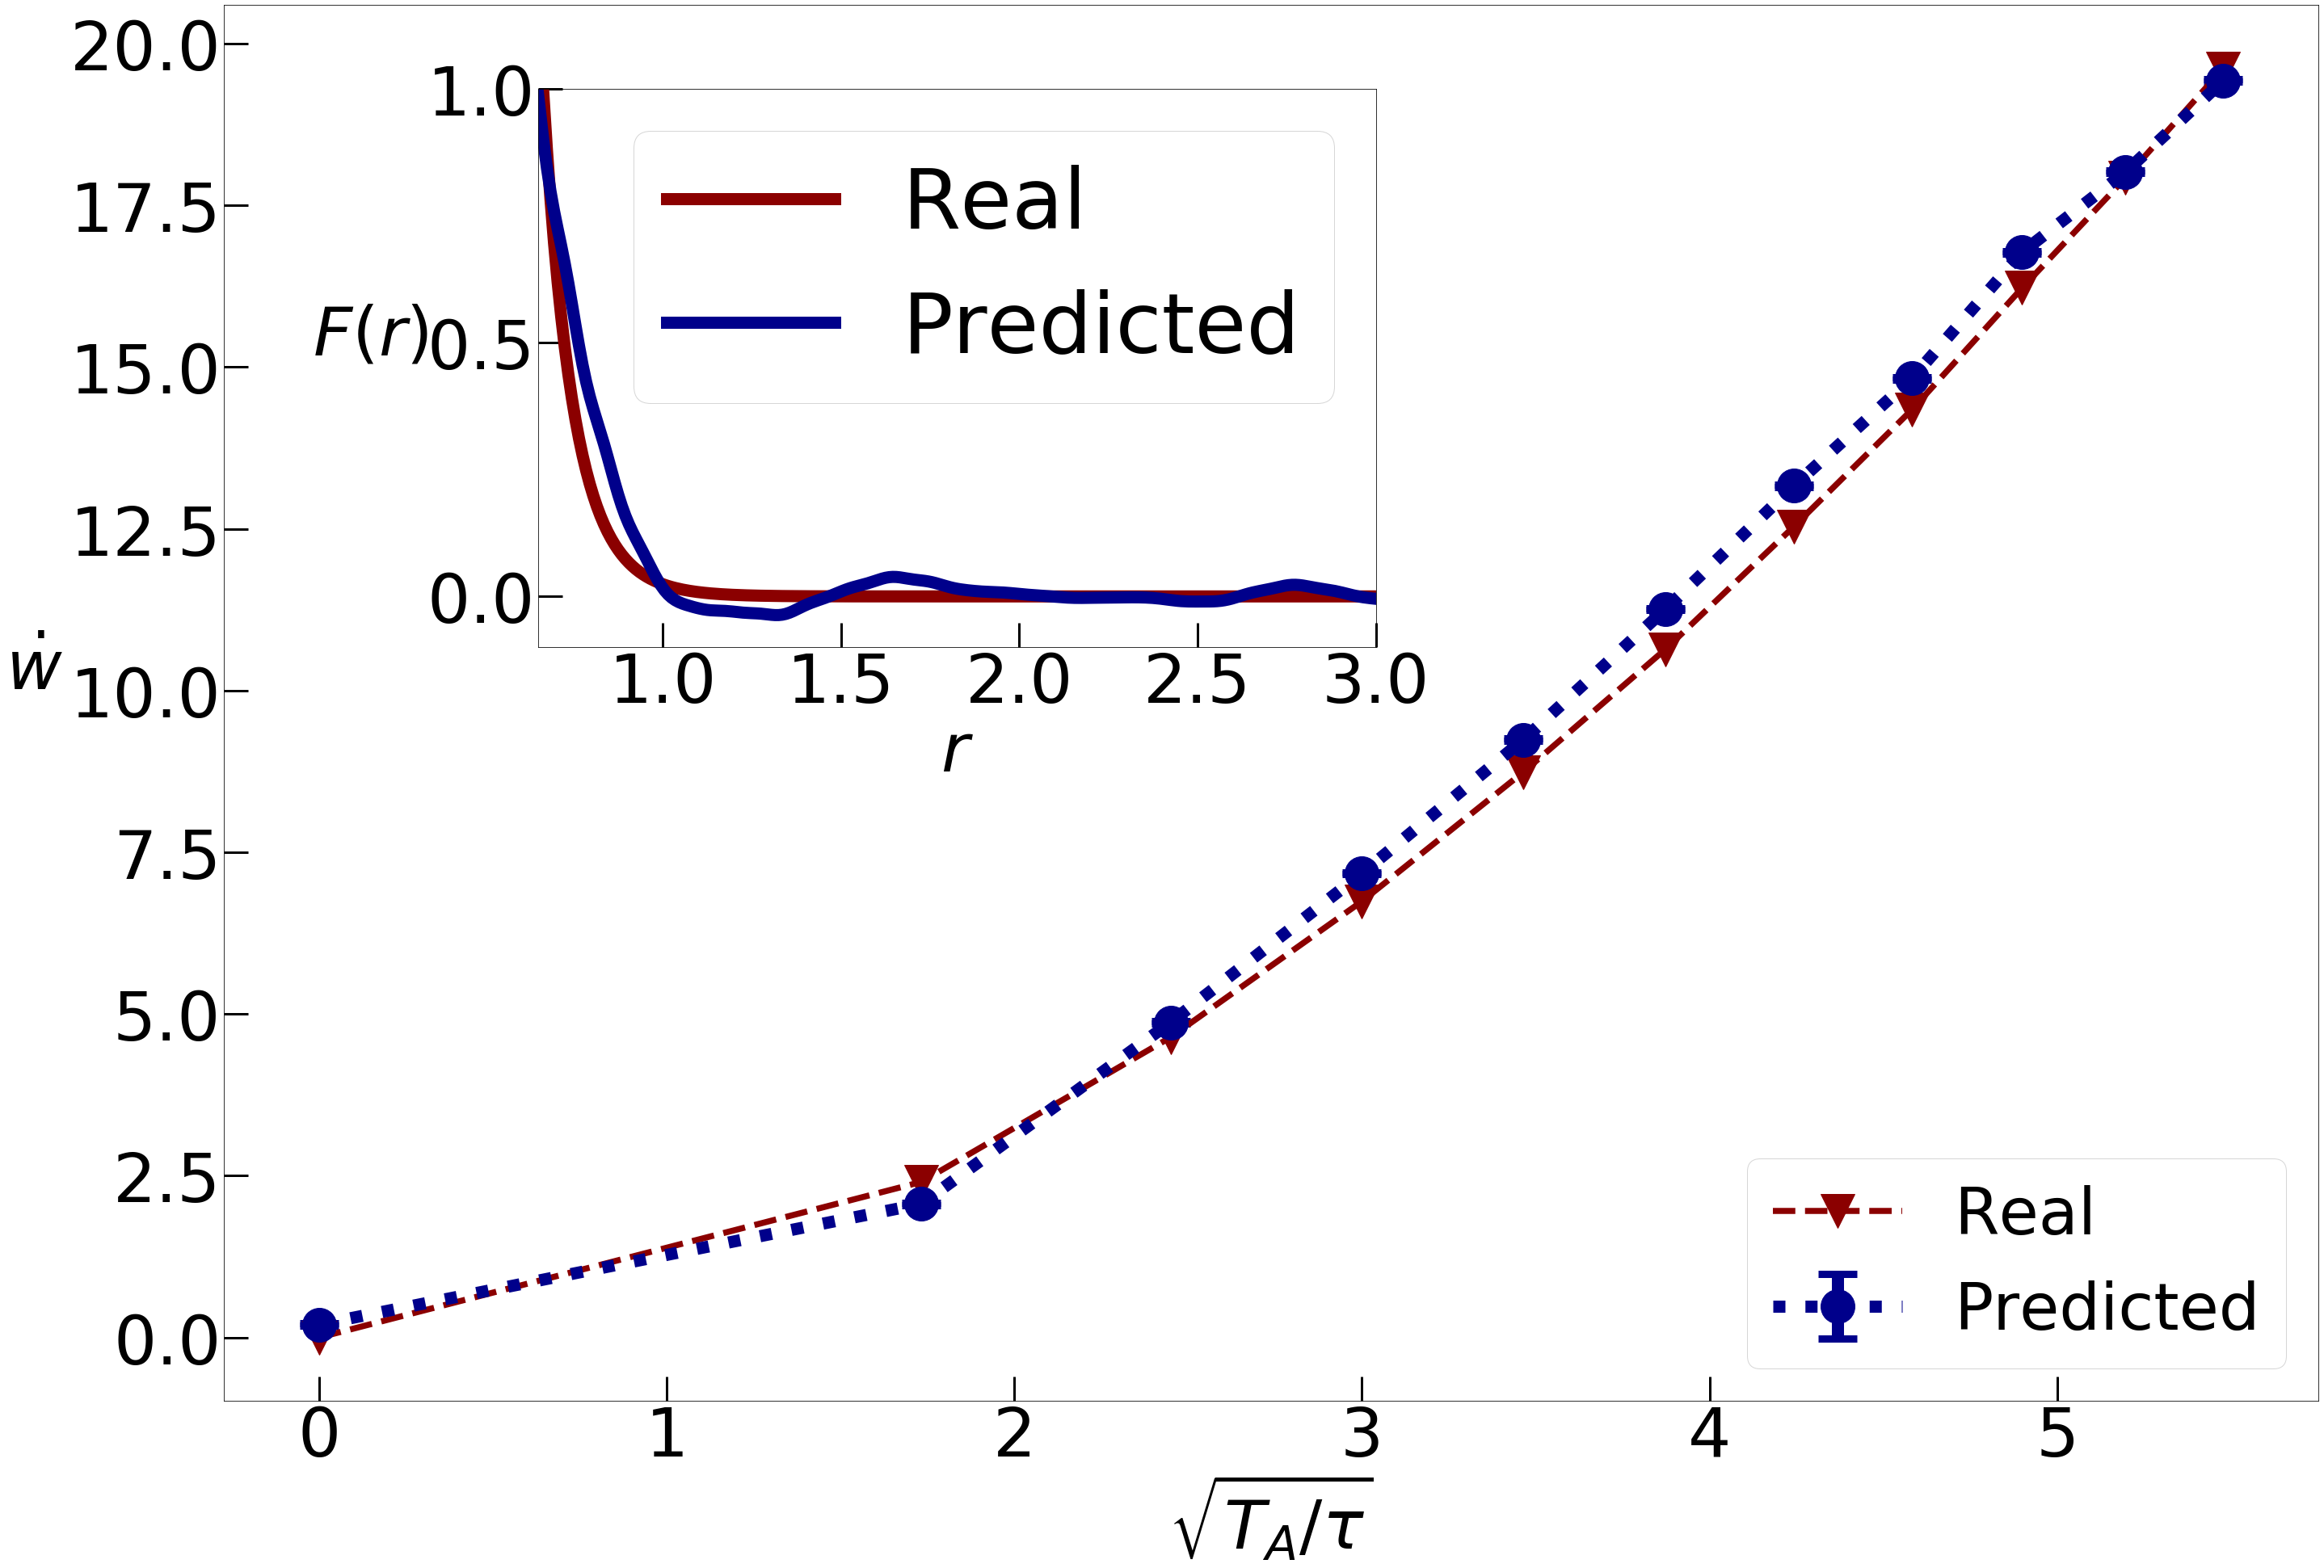

In [12]:
# This snippet is meant to be self-contained for plotting purposes 
from __future__ import division
import math
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rc
import pandas as pd
import numpy as np

SMALL_SIZE = 48
MEDIUM_SIZE = 64
LARGE_SIZE = 80
#plt.rc('font', size=SMALL_SIZE)
#plt.rc('axes', titlesize=LARGE_SIZE)
#plt.rc('axes', labelsize=LARGE_SIZE)
#plt.rc('xtick', labelsize=MEDIUM_SIZE)
#plt.rc('ytick', labelsize=MEDIUM_SIZE)
#plt.rc('legend', fontsize=SMALL_SIZE)
#plt.rc('figure', titlesize=LARGE_SIZE)
plt.rc('font', size=84)
plt.rc('axes', titlesize=84)
plt.rc('axes', labelsize=84)
plt.rc('xtick', labelsize=84)
plt.rc('ytick', labelsize=84)
plt.rc('legend', fontsize=84)
plt.rc('figure', titlesize=40)




TA_test = [0,3,6,9,12,15,18,21,24,27,30]
n_TA_test = 11

r = np.linspace(0.005,2.995,300)

av_dotw = np.load('Yukawa_av_dotw.npy')
av_dotw_real = np.load('Yukawa_av_dotw_real.npy')
std_dotw = np.load('Yukawa_std_dotw.npy')
av_learned_Rr = np.load('Yukawa_av_learned_Rr.npy')
av_real_Rr = np.load('Yukawa_av_real_Rr.npy')
rescale = np.load('rescale.npy')

fig = plt.figure(figsize=(36,24))
ax1 = fig.add_axes([0,0,1,1])  # standard axes
ax2 = fig.add_axes([0.15, 0.54, 0.4, 0.4])


TAs = [float(i) for i in TA_test]

ax1.errorbar(np.power(TAs,0.5),av_dotw*rescale- 55.48*0.255, yerr=std_dotw, color='darkblue', marker='o', markersize=42, linewidth=15, capsize=24, capthick=9, linestyle=':', label= 'Predicted');
ax1.plot(np.power(TAs,0.5),av_dotw_real*rescale- 55.48*0.255, color='darkred', marker='v',label='Real', linestyle='--', linewidth=7.5,  markersize=42);

ax1.set_xlabel(r'$\sqrt{T_A/\tau} $')
ax1.set_ylabel(r'$\dot{w}$    ', rotation=0)
ax1.legend(loc=4, prop={'size':80})
ax1.yaxis.set_label_coords(-0.075,0.5)
ax1.tick_params(direction='in', length=30, width=3)


ax2.plot(r, av_real_Rr, linewidth=15, linestyle='-', color='darkred', label ='Real')
ax2.plot(r, av_learned_Rr, linewidth=15, linestyle='-', color='darkblue', label ='Predicted')
ax2.set_xlim(0.65, 3)
ax2.set_ylim(-0.1,1)
ax2.set_xlabel(r'$r$')
ax2.set_ylabel(r'$F(r)$', rotation=0)
ax2.set_xticks([1,1.5,2, 2.5, 3])
ax2.legend(loc='upper right')
ax2.yaxis.set_label_coords(-0.2,0.5)
ax2.tick_params(direction='in', length=30, width=3)



plt.savefig('Yukawa_ML.pdf', format='pdf',bbox_inches='tight')